### Importing the libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [3]:
dataset=pd.read_csv(r'UrbanSound8K.csv')

### Extracting the features from the audios

In [5]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=4.0)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.hstack((np.mean(mfcc, axis=1), np.mean(chroma, axis=1),
                          np.mean(mel, axis=1), np.mean(contrast, axis=1)))
    return features


### Preprocessing the dataset

In [7]:
def prepare_dataset(metadata, dataset_path):
    features = []
    labels = []
    
    for i, row in metadata.iterrows():
        file_name = os.path.join(dataset_path, 'fold' + str(row["fold"]), str(row["slice_file_name"]))
        class_label = row["class"]
        try:
            mfccs = extract_features(file_name)
            features.append(mfccs)
            labels.append(class_label)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    
    return np.array(features), np.array(labels)

In [9]:
audio_path=r'Audio'

In [11]:
X, y = prepare_dataset(dataset,audio_path)

### One hot coding (Label Encoding)

In [12]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

### Splitting the dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [43]:
print("Original X_train shape:", X_train.shape)

Original X_train shape: (6985, 187, 1, 1)


In [15]:
num_features = X_train.shape[1]  # Find the actual feature length
print("Number of features:", num_features)


Number of features: 187


In [16]:
# num_features = X.shape[1]  
# X_train = X_train.reshape(X_train.shape[0], num_features, 1, 1)  
# X_test = X_test.reshape(X_test.shape[0], num_features, 1, 1) 

In [51]:
# Reshape data to match Dense network input requirements
X_train = X_train.reshape(X_train.shape[0], num_features)  # Flatten to (num_samples, num_features)
X_test = X_test.reshape(X_test.shape[0], num_features)

In [53]:
 print("Reshaped X_train shape:", X_train.shape)
 print("Reshaped X_test shape:", X_test.shape)

Reshaped X_train shape: (6985, 187)
Reshaped X_test shape: (1747, 187)


In [61]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# model1 = Sequential()
# model1.add(Dense(80, input_dim=40, activation='relu', kernel_regularizer=l2(0.001)))
# model1.add(Dropout(0.3))
# model1.add(Dense(40, activation='relu', kernel_regularizer=l2(0.001)))
# model1.add(Dropout(0.4))
# model1.add(Dense(20, activation='relu', kernel_regularizer=l2(0.001)))
# model1.add(Dense(10, activation='softmax'))

model1 = Sequential()
model1.add(Dense(128, input_dim=num_features, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(Dropout(0.4))
model1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(BatchNormalization())
model1.add(Dense(10, activation='softmax'))



optimizer=Adamax(learning_rate=1e-4)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,858 (136.16 KB)

 Trainable params: 34,794 (135.91 KB)

 Non-trainable params: 64 (256.00 B)

In [67]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_lr=1e-6, verbose=1)

In [69]:
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[earlystop,reduce_lr], epochs=100)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.4401 - loss: 1.8229 - val_accuracy: 0.5146 - val_loss: 1.6799 - learning_rate: 1.0000e-04
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.4574 - loss: 1.8149 - val_accuracy: 0.5146 - val_loss: 1.6741 - learning_rate: 1.0000e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.4406 - loss: 1.8265 - val_accuracy: 0.5243 - val_loss: 1.6690 - learning_rate: 1.0000e-04
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.4351 - loss: 1.8302 - val_accuracy: 0.5220 - val_loss: 1.6604 - learning_rate: 1.0000e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.4444 - loss: 1.8190 - val_accuracy: 0.5249 - val_loss: 1.6625 - learning_rate: 1.0000e-04
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.4348 - loss: 1.8151 - val_accuracy: 0.5323 - val_loss: 1.6473 - learning_rate: 1.0000e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 59

In [75]:
# Evaluating The Model
score = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))
score = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 69.22%
Testing Accuracy: 67.83%


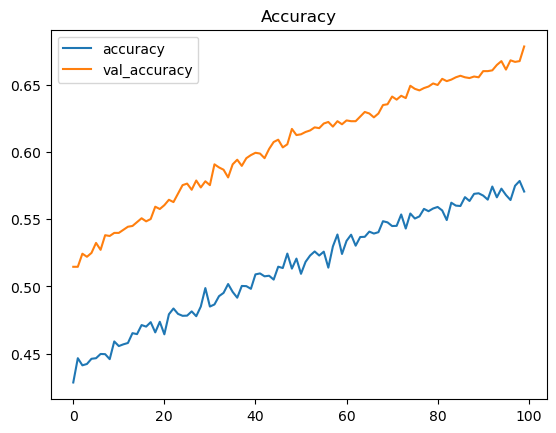

In [77]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

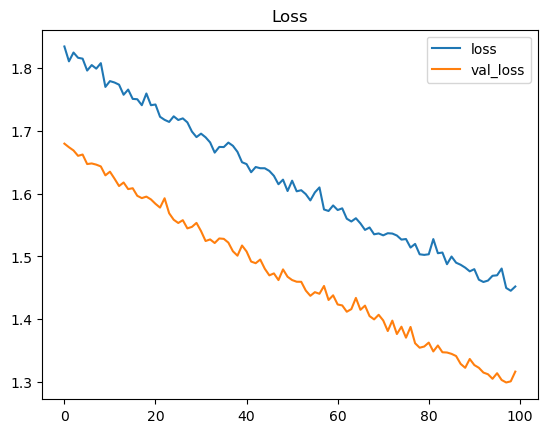

In [79]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model_lstm = Sequential()

# Bidirectional LSTM Layer
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(num_features, 1)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.3))

# Second LSTM Layer (without return_sequences for dense layers)
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.4))

# Fully Connected Layers
model_lstm.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model_lstm.add(Dropout(0.5))

# Output Layer
model_lstm.add(Dense(10, activation='softmax'))

# Compile the model
optimizer = Adamax(learning_rate=1e-3)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks=[earlystop, reduce_lr],
    epochs=100,
    batch_size=16
)


Epoch 1/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.1341 - loss: 2.8904 - val_accuracy: 0.2616 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 93s 213ms/step - accuracy: 0.2104 - loss: 2.2818 - val_accuracy: 0.4139 - val_loss: 1.6830 - learning_rate: 0.0010
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - accuracy: 0.2851 - loss: 2.0195 - val_accuracy: 0.4774 - val_loss: 1.5093 - learning_rate: 0.0010
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 90s 205ms/step - accuracy: 0.3439 - loss: 1.8440 - val_accuracy: 0.5209 - val_loss: 1.3866 - learning_rate: 0.0010
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.4022 - loss: 1.7061 - val_accuracy: 0.5695 - val_loss: 1.2824 - learning_rate: 0.0010
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.4309 - loss: 1.6067 - val_accuracy: 0.5180 - val_loss: 1.3774 - learning_rate: 0.0010
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 86s 197ms/step - accura

In [87]:
# Evaluating The Model
score = model2.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))
score = model2.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 79.11%
Testing Accuracy: 76.65%


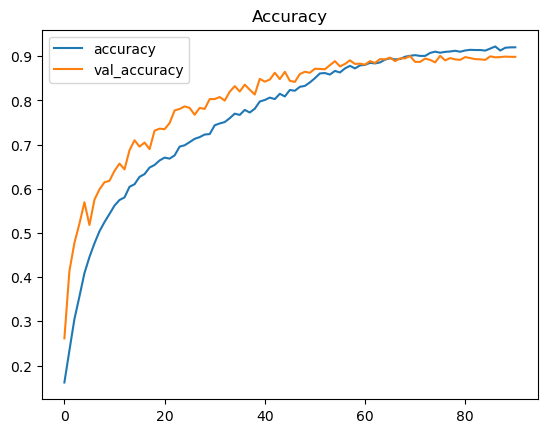

In [89]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

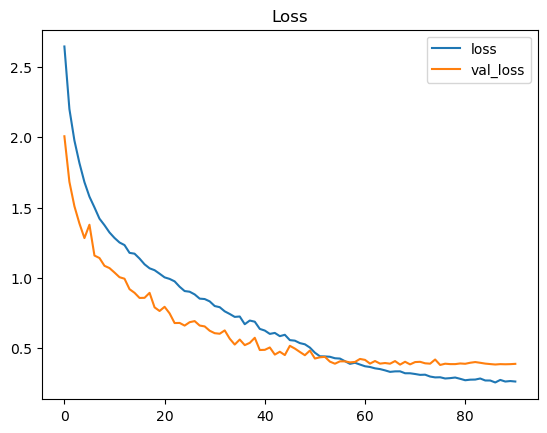

In [91]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [112]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Define the model architecture with the correct number of output units
model = tf.keras.Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(187,)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Adjusted to 10 to match the number of classes
])

# Compile the model with an initial learning rate
initial_learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define a learning rate scheduler to decrease the learning rate during training
# Define a learning rate scheduler with explicit float casting
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(scheduler)


# Add early stopping and reduce learning rate on plateau for efficient training
earlystop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model with increased batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks=[earlystop, reduce_lr, lr_scheduler],
    epochs=100,
    batch_size=32  # Increased batch size for better generalization
)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.1540 - loss: 13.7435 - val_accuracy: 0.1654 - val_loss: 2.4603 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.1494 - loss: 2.6714 - val_accuracy: 0.1826 - val_loss: 2.3529 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.2070 - loss: 2.4163 - val_accuracy: 0.3286 - val_loss: 2.1054 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.2834 - loss: 2.2004 - val_accuracy: 0.3635 - val_loss: 1.9209 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.3238 - loss: 2.0684 - val_accuracy: 0.4533 - val_loss: 1.7700 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.3667 - loss: 1.9417 - val_accuracy: 0.4654 - val_loss: 1.6470 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.

In [114]:
# Evaluating The Model
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))
score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 96.28%
Testing Accuracy: 90.10%


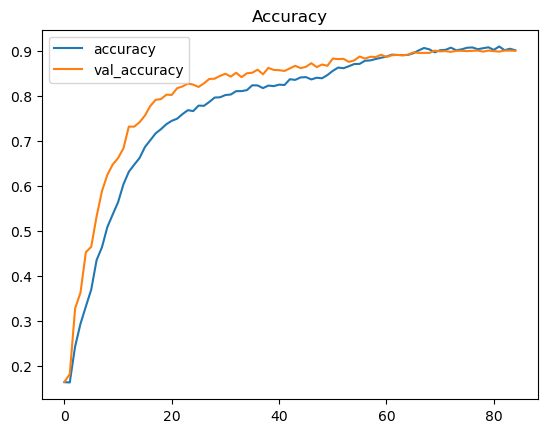

In [116]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

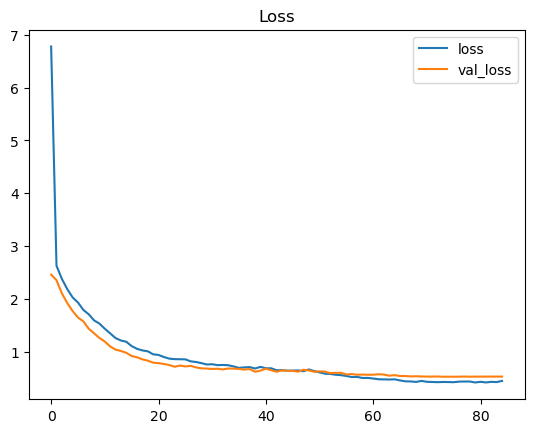

In [118]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### Prediction

In [128]:
def prediction_(path_sound):
    data_sound = extract_features(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1,num_features)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_,axis=1)
    pred_class = le.inverse_transform(pred_)
    print("The predicted class is:\033[01m ", pred_class[0],'\033[0m \n')

In [132]:
import IPython.display as ipd
path_sound = r'Audio/fold8/106905-5-0-0.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The predicted class is:  engine_idling  



In [134]:
path_sound = 'Audio/fold5/100263-2-0-117.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The predicted class is:  children_playing  

